#  Text generation

In order to control the amount of stochasticity in the sampling process, we’ll introduce a parameter called the softmax temperature, which characterizes the entropy of the
probability distribution used for sampling: it characterizes how surprising or predictable the choice of the next word will be. Given a temperature value, a new probability
distribution is computed from the original one (the softmax output of the model) by
reweighting it in the following way

In [ ]:
import numpy as np
def reweight_distribution(original_distribution, temperature=0.5): # original_distribution is a 1D NumPy array of probability values that must sum to 1. temperature is a factor quantifying the entropy of the output distribution.
 distribution = np.log(original_distribution) / temperature
 distribution = np.exp(distribution)
 # Returns a reweighted version of the original distribution. The sum of the distribution may no longer be 1, so you divide it by its sum to obtain the new distribution.
 return distribution / np.sum(distribution)

Higher temperatures result in sampling distributions of higher entropy that will generate more surprising and unstructured generated data, whereas a lower temperature will
result in less randomness and much more predictable generated data

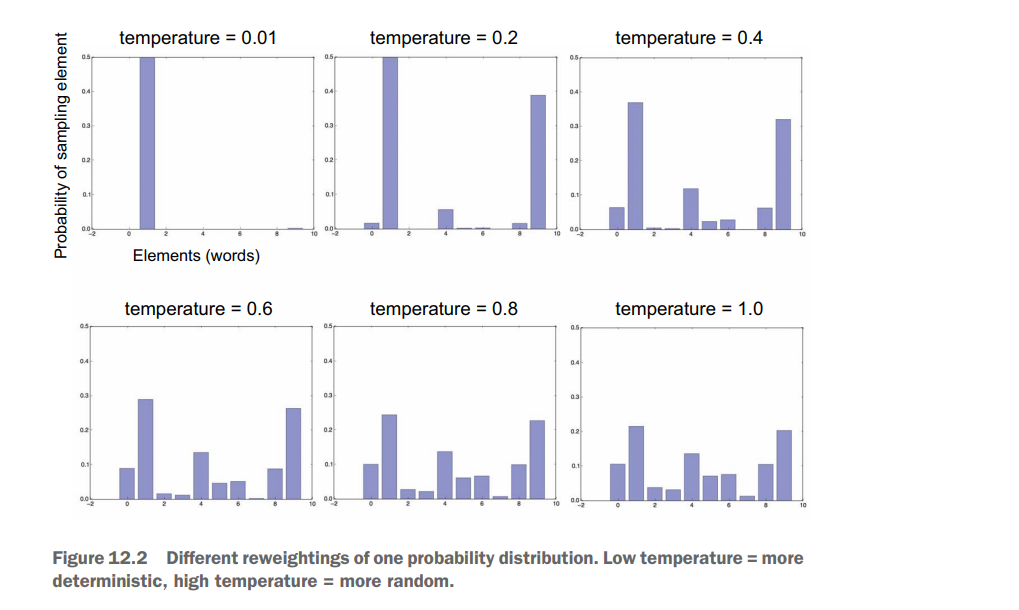

#  Implementing text generation with Keras

The first thing you need
is a lot of text data that you can use to learn a language model. You can use any sufficiently large text file or set of text files—Wikipedia, The Lord of the Rings, and so on

In this example, we’ll keep working with the IMDB movie review dataset and we’ll learn to generate never-read-before movie reviews. As such, our
language model will be a model of the style and topics of these movie reviews specifically, rather than a general model of the English language.

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2024-01-01 17:01:24--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  10.1MB/s    in 15s     

2024-01-01 17:01:40 (5.45 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



You’re already familiar with the structure of the data: we get a folder named aclImdb
containing two subfolders, one for negative-sentiment movie reviews, and one for
positive-sentiment reviews. There’s one text file per review. We’ll call text_dataset_
from_directory with label_mode=None to create a dataset that reads from these files
and yields the text content of each file.

In [ ]:
import tensorflow as tf
from tensorflow import keras
dataset = keras.utils.text_dataset_from_directory(directory="aclImdb", label_mode=None, batch_size=256)

# Strip the <br /> HTML tag that occurs in many of the reviews. This did not matter much for text classification, but we wouldn’t want to generate <br /> tags in this example!
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 100006 files belonging to 1 classes.


Now let’s use a TextVectorization layer to compute the vocabulary we’ll be working
with. We’ll only use the first sequence_length words of each review: our TextVectorization layer will cut off anything beyond that when vectorizing a text.

In [ ]:
from tensorflow.keras.layers import TextVectorization
sequence_length = 100
vocab_size = 15000 # We’ll only consider the top 15,000 most common words—anything else will be treated as the out-of-vocabulary token, "[UNK]".
text_vectorization = TextVectorization(
 max_tokens=vocab_size,
 output_mode="int",
 output_sequence_length=sequence_length, # We’ll work with inputs and targets of length 100 (but since we’ll offset the targets by 1, the model will actually see sequences of length 99).
)
text_vectorization.adapt(dataset)

Let’s use the layer to create a language modeling dataset where input samples are vectorized texts, and corresponding targets are the same texts offset by one word.

In [ ]:
def prepare_lm_dataset(text_batch):
 vectorized_sequences = text_vectorization(text_batch) # Convert a batch of texts (strings) to a batch of integer sequences.
 x = vectorized_sequences[:, :-1] # Create inputs by cutting off the last word of the sequences.
 y = vectorized_sequences[:, 1:] # Create targets by offsetting the sequences by 1.
 return x, y

lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls=4)

In [ ]:
from tensorflow.keras import layers

In [ ]:
class PositionalEmbedding(layers.Layer):
 def __init__(self, sequence_length, input_dim, output_dim, **kwargs): # A downside of position embeddings is that the sequence length needs to be known in advance
    super().__init__(**kwargs)
    self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim) # Prepare an Embedding layer for the token indices.
    self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # And another one for the token positions
    self.sequence_length = sequence_length
    self.input_dim = input_dim
    self.output_dim = output_dim

 def call(self, inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1) # delta=1: The step size between consecutive values in the sequence is 1.
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions # Add both embedding vectors together.

 def compute_mask(self, inputs, mask=None):
    # Like the Embedding layer, this layer should be able to generate a mask so we can ignore padding 0s in the inputs. The compute_mask method will called automatically by the framework, and the mask will get propagated
    # to the next layer.
    return tf.math.not_equal(inputs, 0)

 def get_config(self):
    # Implement serialization so we can save the model.
    config = super().get_config()
    config.update({
      "output_dim": self.output_dim,
      "sequence_length": self.sequence_length,
      "input_dim": self.input_dim,
    })
    return config

In [ ]:
# The TransformerDecoder
class TransformerDecoder(layers.Layer):
 def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim, activation="relu"),
        layers.Dense(embed_dim),]
    )
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.layernorm_3 = layers.LayerNormalization()
    self.supports_masking = True # This attribute ensures that the layer will propagate its input mask to its outputs; masking in Keras is explicitly opt-in. If you pass a mask to a layer that doesn’t
    # Implement compute_mask() and that doesn’t expose this supports_masking attribute, that’s an error.
 def get_config(self):
    config = super().get_config()
    config.update({
      "embed_dim": self.embed_dim,
      "num_heads": self.num_heads,
      "dense_dim": self.dense_dim,
    })
    return config
 def get_causal_attention_mask(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i >= j, dtype="int32") # Generate matrix of shape (sequence_length, sequence_length) with 1s in one half and 0s in the other

    # Replicate it along the batch axis to get a matrix of shape (batch_size, sequence_length, sequence_length)
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult = tf.concat([tf.expand_dims(batch_size, -1),tf.constant([1, 1], dtype=tf.int32)], axis=0)
    return tf.tile(mask, mult)

 def call(self, inputs, encoder_outputs, mask=None):
    causal_mask = self.get_causal_attention_mask(inputs)
    if mask is not None:
      # Prepare the input mask (that describes padding locations in the target sequence).
      padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
      padding_mask = tf.minimum(padding_mask, causal_mask) # Merge the two masks together.
    attention_output_1 = self.attention_1(query=inputs,value=inputs,key=inputs,attention_mask=causal_mask) # Pass the causal mask to the first attention layer, which performs self-attention over the target sequence.
    attention_output_1 = self.layernorm_1(inputs + attention_output_1)
    attention_output_2 = self.attention_2(
    query=attention_output_1,value=encoder_outputs,key=encoder_outputs,attention_mask=padding_mask,) # Pass the combined mask to the second attention layer, which relates the source sequence to the target sequence.
    attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)
    proj_output = self.dense_proj(attention_output_2)
    return self.layernorm_3(attention_output_2 + proj_output)


setup you can use for sequence-tosequence learning in the general case: feed the source sequence into an encoder, and
then feed both the encoded sequence and the target sequence into a decoder that tries
to predict the same target sequence offset by one step. When you’re doing text generation, there is no source sequence: you’re just trying to predict the next tokens in the target sequence given past tokens, which we can do using only the decoder. And thanks to
causal padding, the decoder will only look at words 0…N to predict the word N+1.

In [ ]:
from tensorflow.keras import layers
embed_dim = 256
latent_dim = 2048
num_heads = 2
inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")

# A text-generation callback with variable-temperature sampling

We’ll use a callback to generate text using a range of different temperatures after
every epoch. This allows you to see how the generated text evolves as the model
begins to converge, as well as the impact of temperature in the sampling strategy. To seed text generation, we’ll use the prompt “this movie”: all of our generated texts
will start with this.

In [ ]:
import numpy as np
tokens_index = dict(enumerate(text_vectorization.get_vocabulary())) # Dict that maps word indices back to strings, to be used for text decoding

In [ ]:
def sample_next(predictions, temperature=1.0): # Implements variable temperature sampling from a probability distribution
 predictions = np.asarray(predictions).astype("float64")
 predictions = np.log(predictions) / temperature
 exp_preds = np.exp(predictions)
 predictions = exp_preds / np.sum(exp_preds)
 probas = np.random.multinomial(1, predictions, 1)
 return np.argmax(probas)

In [ ]:
class TextGenerator(keras.callbacks.Callback):
 def __init__(self,
              prompt, # Prompt that we use to seed text generation
              generate_length, # How many words to generate
              model_input_length,
              temperatures=(1.,),  # Range of temperatures to use for sampling
              print_freq=1):
    self.prompt = prompt
    self.generate_length = generate_length
    self.model_input_length = model_input_length
    self.temperatures = temperatures
    self.print_freq = print_freq
 def on_epoch_end(self, epoch, logs=None):
    if (epoch + 1) % self.print_freq != 0:
      return
    for temperature in self.temperatures:

      print("== Generating with temperature", temperature)
      sentence = self.prompt # When generating text, we start from our prompt.

      for i in range(self.generate_length):
        # Feed the current sequence into our model.
        tokenized_sentence = text_vectorization([sentence])
        predictions = self.model(tokenized_sentence)

        # Retrieve the predictions for the last timestep, and use them to sample a new word.
        next_token = sample_next(predictions[0, i, :])
        sampled_token = tokens_index[next_token]

        # Append the new word to the current sequence and repeat.
        sentence += " " + sampled_token
      print(sentence)

In [ ]:
prompt = "This movie"
text_gen_callback = TextGenerator(
 prompt,
 generate_length=50,
 model_input_length=sequence_length,
 temperatures=(0.2, 0.5, 0.7, 1., 1.5)) # We’ll use a diverse range of temperatures to sample text, to demonstrate the effect of temperature on text generation.

. Note that punctuation isn’t part of our vocabulary, so none of our generated text has any punctuation

In [ ]:
model.fit(lm_dataset, epochs=200, callbacks=[text_gen_callback])

Epoch 1/200
391/391 [==============================] - ETA: 0s - loss: 5.9270== Generating with temperature 0.2
This movie footage was is a on seemingly besides of the rich certainly tons the for story sentence shows and the acting is of a the good [UNK] moments [UNK] movie a was kid beyond i [UNK] fictional of stops audience in too [UNK] small wants central to story play however who
== Generating with temperature 0.5
This movie is has fun an a larger great but way i it had was to horrible any purpose barrymore it just makes 300 dark it allan is [UNK] so the boring joke and in this a movie [UNK] [UNK] in opposite the of [UNK] this [UNK] was of pretty nudity awful
== Generating with temperature 0.7
This movie may had show a was very both pleased part by and the lacks movie any is [UNK] the directed later which i made can that be starring bad currently scene projected and it i naturally would flipped never [UNK] like that the had second to [UNK] me more going joke
== Generating with temp

KeyboardInterrupt: ignored

As you can see, a low temperature value results in very boring and repetitive text and
can sometimes cause the generation process to get stuck in a loop. With higher temperatures, the generated text becomes more interesting, surprising, even creative.
With a very high temperature, the local structure starts to break down, and the output
looks largely random. Here, a good generation temperature would seem to be about
0.7. Always experiment with multiple sampling strategies! A clever balance between
learned structure and randomness is what makes generation interesting.

**GPT-3 is effectively the same thing as what we trained in this example, but with a**
**deep stack of Transformer decoders, and a much bigger training corpus**

Wrapping up


 You can generate discrete sequence data by training a model to predict the next
token(s), given previous tokens.


 In the case of text, such a model is called a language model. It can be based on
either words or characters.


 Sampling the next token requires a balance between adhering to what the
model judges likely, and introducing randomness.


 One way to handle this is the notion of softmax temperature. Always experiment with different temperatures to find the right one.